In [ ]:
import os
import sys
import random

isColab = "google.colab" in sys.modules
# this also works:
# isColab = "COLAB_GPU" in os.environ

if isColab:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

    colab_path = ("/content/drive/Shared with me"
        + "/Colab Notebooks/Conditional_GAN")

Mounted at /content/drive


Preprocessing and image labeling

In [ ]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Flatten  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

# Function to label images in a directory hierarchy based on folder names
def label_images(base_path):
    image_paths = []  # List to store paths to each image
    labels = []  # List to store corresponding labels for images

    # List main directories under base_path; these directories act as labels
    main_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

    # Iterate over each main folder (each considered a unique label)
    for label, folder in enumerate(main_folders):
        folder_path = os.path.join(base_path, folder)  # Full path to the folder

        # List sub-directories within each main folder
        sub_folders = [sf for sf in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, sf))]

        # Iterate over each sub-folder
        for sub_folder in sub_folders:
            sub_folder_path = os.path.join(folder_path, sub_folder)  # Full path to the sub-folder

            # Iterate over files in sub-folder
            for image_name in os.listdir(sub_folder_path):
                # Check if file is an image based on its extension
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    image_path = os.path.join(sub_folder_path, image_name)  # Full path to the image
                    image_paths.append(image_path)  # Add path to list
                    labels.append(label)  # Add label to list (label is the index of main folder)

    return image_paths, labels  # Return lists of image paths and their corresponding labels

# Set the base path to the dataset directory
base_path = '/content/drive/Shareddrives/Conditional_GAN_Drive/Conditional_GAN/arcDataset'


Split into test and train:

In [ ]:
import random  # Required for shuffling the data

# Call the function to get image paths and labels
image_paths, labels = label_images(base_path)

# Combine the image paths and labels into a list of tuples to keep them together during shuffling
combined = list(zip(image_paths, labels))

# Shuffle the combined list to randomize the order of data
random.shuffle(combined)

# Prepare lists to hold the shuffled image paths and labels separately
shuffled_image_paths = []
shuffled_labels = []

# Unzip the shuffled list of tuples back into separate lists
for item in combined:
    shuffled_image_paths.append(item[0])
    shuffled_labels.append(item[1])

# Determine the point to split the data into training and testing (80% training, 20% testing)
split_point = int(0.8 * len(shuffled_image_paths))

# Slice the lists to create training datasets
train_paths = shuffled_image_paths[:split_point]
train_labels = shuffled_labels[:split_point]

# Slice the lists to create testing datasets
test_paths = shuffled_image_paths[split_point:]
test_labels = shuffled_labels[split_point:]


Preprocess images into Tensors that model can understand:

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # To convert labels into one-hot format

# Function to preprocess images
def preprocess_image(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as a JPEG file, with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to 40x40 pixels
    image = tf.image.resize(image, [40, 40])
    # Normalize the image by dividing pixel values by 255.0
    image /= 255.0
    # Return the processed image
    return image

# Adjust the labels for zero-indexing and convert them to one-hot format
train_labels_one_hot = to_categorical([label - 1 for label in train_labels], 7)
test_labels_one_hot = to_categorical([label - 1 for label in test_labels], 7)

# Create a TensorFlow dataset from the paths and one-hot encoded labels for training
# Limiting to the first 120 samples for potentially reducing training size or resource constraints
train_data = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_one_hot))
# Map the preprocessing function to the dataset
train_data = train_data.map(lambda x, y: (preprocess_image(x), y))
# Batch the dataset with a size of 32 items per batch
train_data = train_data.batch(32)

# Create a TensorFlow dataset from the paths and one-hot encoded labels for testing
test_data = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_one_hot))
# Map the preprocessing function to the dataset
test_data = test_data.map(lambda x, y: (preprocess_image(x), y))
# Batch the dataset with a size of 32 items per batch
test_data = test_data.batch(32)


CGAN

In [ ]:
batch_size = 32
num_channels = 3
num_classes = 7
image_size = 256
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

135 10


Discriminator and Generator


In [ ]:
from keras import regularizers
import tensorflow as tf

# Define the discriminator model
discriminator = tf.keras.Sequential([
    # Input layer specifying input shape
    tf.keras.layers.InputLayer((40, 40, discriminator_in_channels)),
    # First convolutional layer with L1 regularization
    tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same", kernel_regularizer=regularizers.L1(0.01)),
    # Leaky ReLU activation with a small slope for negative values
    tf.keras.layers.LeakyReLU(alpha=0.2),
    # Dropout for regularization by randomly setting a fraction of input units to 0
    tf.keras.layers.Dropout(0.3),
    # Second convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same", kernel_regularizer=regularizers.L1(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.3),
    # Batch normalization to stabilize learning
    tf.keras.layers.BatchNormalization(),
    # Third convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_regularizer=regularizers.L1(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    # Flatten the output to feed into a dense layer
    tf.keras.layers.Flatten(),
    # Output dense layer with 1 unit for binary classification
    tf.keras.layers.Dense(1),
], name="discriminator")

### Generator
# Define the generator model
generator = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.InputLayer((generator_in_channels,)),
    # Dense layer, expanded to required dimensions
    tf.keras.layers.Dense(7 * 7 * generator_in_channels * 4, kernel_regularizer=regularizers.L1(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    # Reshape output into feature map format
    tf.keras.layers.Reshape((7, 7, generator_in_channels * 4)),

    # Series of transposed convolutional layers to upsample the input
    tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),

    # Cropping layers to adjust the output size to the target size
    tf.keras.layers.Cropping2D(((6, 6), (6, 6))),  # Crop to 100x100
    tf.keras.layers.Cropping2D(((30, 30), (30, 30))),  # Final crop to 40x40

    # Final transposed convolutional layer to get to desired channel count and activation
    tf.keras.layers.Conv2DTranspose(num_channels, (3, 3), strides=(1, 1), padding="same", activation="tanh"),
], name="generator")


CGAN Train Code

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        print("here")
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.Generator.from_seed(1337)
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.gen_acc_tracker = tf.keras.metrics.Mean(name="generator_accuracy")
        self.disc_acc_tracker = tf.keras.metrics.Mean(name="discriminator_accuracy")
        self.gen_acc_values = []  # List to store generator accuracy for each epoch
        self.disc_acc_values = []  # List to store discriminator accuracy for each epoch
        self.gen_loss_values = []  # List to store generator accuracy for each epoch
        self.disc_loss_values = []  # List to store discriminator accuracy for each epoch
        self.epochs = 0

    @property
    def metrics(self):
        self.epochs+=1
        if(self.gen_acc_tracker.result()!=0):
          self.gen_acc_values.append(self.gen_acc_tracker.result())
        if(self.disc_acc_tracker.result()!=0):
          self.disc_acc_values.append(self.disc_acc_tracker.result())
        if(self.gen_loss_tracker.result()!=0):
          self.gen_loss_values.append(self.gen_loss_tracker.result())
        if(self.disc_loss_tracker.result()!=0):
          self.disc_loss_values.append(self.disc_loss_tracker.result())
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_acc_tracker, self.disc_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn, acc_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.acc_fn = acc_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so they can be concatenated with the images.
        image_one_hot_labels = tf.repeat(one_hot_labels[:, :, None, None], repeats=[40 * 40], axis=3)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 40, 40, num_classes))

        # Sample random points in the latent space and concatenate the labels.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = self.seed_generator.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Generate fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Labels discriminating real from fake images.
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator once.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            d_acc = self.acc_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the generator multiple times, for example, 3 times.
        num_generator_updates = 3
        for _ in range(num_generator_updates):
            # Sample new random points for the generator.
            random_latent_vectors = self.seed_generator.normal(shape=(batch_size, self.latent_dim))
            random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

            # Misleading labels for the generator.
            misleading_labels = tf.ones((batch_size, 1))

            # Train the generator.
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_vector_labels)
                fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
                predictions = self.discriminator(fake_image_and_labels)
                g_loss = self.loss_fn(misleading_labels, predictions)
                g_acc = self.acc_fn(tf.ones_like(predictions), predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update losses.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        self.gen_acc_tracker.update_state(g_acc) #y_true, y_pred
        self.disc_acc_tracker.update_state(d_acc) #y_true, y_pred #FAKE

        # self.gen_acc_values.append(0.6)
        # self.disc_acc_values.append(0.6)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_acc": self.gen_acc_tracker.result(),
            "d_acc": self.disc_acc_tracker.result(),
        }

    def plot_accuracy(self):
        epochs = range(1, len(self.gen_acc_values) + 1)

        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.gen_acc_values, label='Generator Accuracy')
        plt.plot(epochs, self.disc_acc_values, label='Discriminator Accuracy')
        plt.title('Generator and Discriminator Accuracy')
        plt.xlabel('Batches')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_loss(self):
        epochs = range(1, len(self.gen_loss_values) + 1)

        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.gen_loss_values, label='Generator Loss')
        plt.plot(epochs, self.disc_loss_values, label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


here
Epoch 1/8
1/1 [==============================] - 8s 8s/step - g_loss: 0.0182 - d_loss: 0.1926 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 2/8
1/1 [==============================] - 2s 2s/step - g_loss: 0.0162 - d_loss: 0.1736 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 3/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0142 - d_loss: 0.1545 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 4/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0126 - d_loss: 0.1364 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 5/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0112 - d_loss: 0.1192 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 6/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0100 - d_loss: 0.1030 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 7/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0089 - d_loss: 0.0880 - g_acc: 1.0000 - d_acc: 1.0000
Epoch 8/8
1/1 [==============================] - 1s 1s/step - g_loss: 0.0079 - d_loss: 0.0744 - g_acc: 1.0000 - d

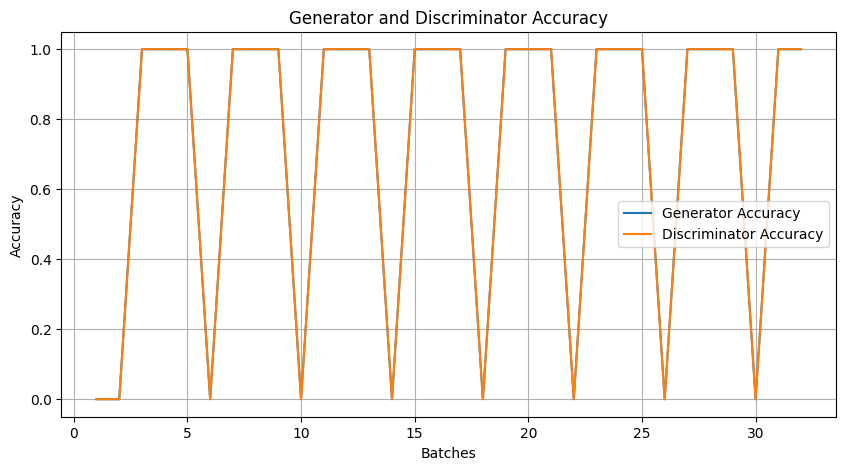

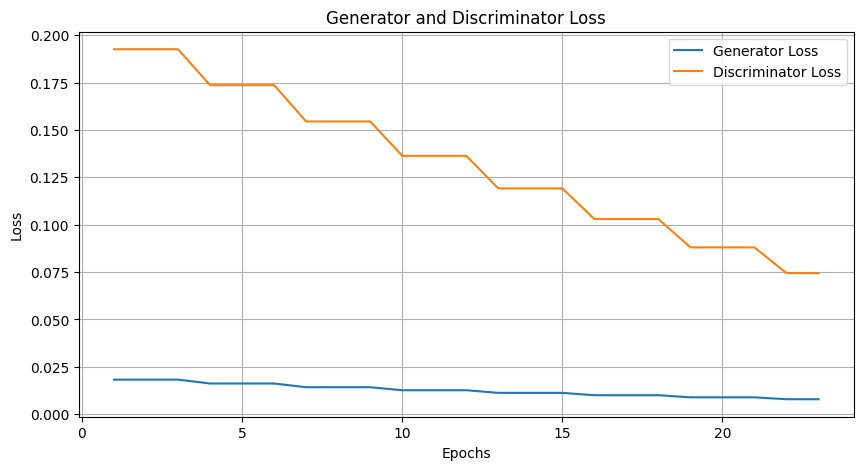

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)

# Compile the GAN
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    acc_fn=tf.keras.metrics.binary_accuracy
)

# Train the GAN
# Ensure you are using train_data which is already batched and preprocessed
# (train_data, test_data), (_, _) = tf.keras.datasets.mnist.load_data()
cond_gan.fit(train_data, epochs=8)
cond_gan.plot_accuracy()
cond_gan.plot_loss()


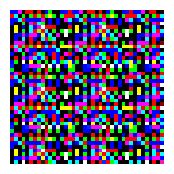

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_class(cgan, class_label, latent_dim, num_classes):
    """

    Args:
    cgan (tf.keras.Model): The trained Conditional GAN model.
    class_label (int): The class label to generate the image for.
    latent_dim (int): Dimension of the latent space.
    num_classes (int): Total number of classes.

    Returns:
    np.array: The generated image as a numpy array.
    """

    one_hot_vector = tf.keras.utils.to_categorical([class_label], num_classes=num_classes)

    random_latent_vector = tf.random.normal(shape=(1, latent_dim))

    combined_input = tf.concat([random_latent_vector, one_hot_vector], axis=1)

    generated_image = cgan.generator(combined_input)
    generated_image = (generated_image.numpy().squeeze() * 255).astype(np.uint8)

    return generated_image

class_label = 3
generated_image = generate_image_from_class(cond_gan, class_label, latent_dim, num_classes)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image)
plt.axis('off')
plt.show()